Package Import

In [43]:
import pandas as pd
import numpy as np
import gc
import shap
import torch
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,classification_report, f1_score, roc_curve, auc, recall_score, confusion_matrix, brier_score_loss
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

User Configuration

In [44]:
# Specify your datset location and label column name
dataset = "Your dataset location"
label_column = 'Your label column name'

# Assign your optimized hyperparameters for your XGBoost model
params = {'booster': 'dart', 'max_depth': 9, 'learning_rate': 0.16757526880337048, 'n_estimators': 271, 'min_child_weight': 10, 'subsample': 0.6462807491201441, 'colsample_bytree': 0.899034861491886, 'gamma': 0.5134323315817606, 'lambda': 0.33831616398436576, 'alpha': 0.11680506336726469}

# Specify the number of dataset random state splits for evaluation of calibration scores
random_state_num = 30

Data & Function Preperation

In [ ]:
# Load the dataset using Pandas
df = pd.read_excel(dataset)

# Specify the target column name
target_name = 'Cancer Label'

X = df.drop(columns=[label_column])
y = df[label_column]

# Encode categorical variables if needed
for column in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])

In [45]:
def evaluate_model_across_splits(model, X, y, n_splits=30, test_size=0.2):
    
    all_test_probs = []
    all_test_true = []
    split_results = []
    
    for random_state in tqdm(range(n_splits), desc="Evaluating model across splits", ncols=100):
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )
        
        # Train model
        model.fit(X_train, y_train)
        
        # Get predictions
        test_probs = model.predict_proba(X_test)[:, 1]
        
        # Store results
        all_test_probs.extend(test_probs)
        all_test_true.extend(y_test)
        
        # Store individual split results
        split_results.append({
            'random_state': random_state,
            'test_probs': test_probs,
            'test_true': y_test,
            'brier_score': brier_score_loss(y_test, test_probs)
        })
    
    return {
        'pooled_probs': np.array(all_test_probs),
        'pooled_true': np.array(all_test_true),
        'split_results': split_results
    }



def plot_pooled_calibration(results, n_splits=30):
    fig, ax = plt.subplots(figsize=(8, 6))

    # Pooled Calibration Curve
    prob_true, prob_pred = calibration_curve(
        results['pooled_true'],
        results['pooled_probs'],
        n_bins=10,
        strategy='quantile'  # Use quantile binning for more reliable estimates
    )

    ax.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
    ax.plot(prob_pred, prob_true, 's-', label='Model')

    ax.set_xlabel('Mean predicted probability', fontsize=18)
    ax.set_ylabel('Empirical probability', fontsize=18)
    ax.set_title(f'Pooled Calibration Curve\n(from {n_splits} random splits)', fontsize=18)
    ax.tick_params(axis='both', labelsize=16)
    ax.legend(loc='lower right', fontsize=16)
    ax.grid(True)

    plt.tight_layout()
    return fig, ax

def analyze_brier_scores(results):
    # Extract split Brier scores from the precomputed results
    brier_scores = [split['brier_score'] for split in results['split_results']]

    # Convert to numpy array for easier analysis
    brier_scores = np.array(brier_scores)

    # Calculate statistical measures
    stats_summary = {
        'mean': np.mean(brier_scores),
        'std': np.std(brier_scores),
        'median': np.median(brier_scores),
        'ci_95': stats.norm.interval(0.95, loc=np.mean(brier_scores), scale=stats.sem(brier_scores))
    }

    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(19, 6))

    # Plot 1: Brier scores across trials
    ax1.plot(range(1, len(brier_scores) + 1), brier_scores, 'b-', label='Brier Score')
    ax1.axhline(y=stats_summary['mean'], color='r', linestyle='--', label=f"Mean: {stats_summary['mean']:.4f}")
    ax1.fill_between(range(1, len(brier_scores) + 1),
                     stats_summary['ci_95'][0], stats_summary['ci_95'][1],
                     alpha=0.2, color='gray', label='95% CI')
    ax1.set_xlabel('Random State Trial', fontsize=15)
    ax1.set_ylabel('Brier Score', fontsize=18)
    ax1.tick_params(axis='y', labelsize=15)
    ax1.set_title('Brier Scores Across Random State Trials', fontsize=18)
    ax1.legend(fontsize=16)
    ax1.grid(True)

    # Plot 2: Distribution of Brier scores
    sns.histplot(brier_scores, kde=True, ax=ax2)
    ax2.axvline(x=stats_summary['mean'], color='r', linestyle='--', label=f"Mean: {stats_summary['mean']:.4f}")
    ax2.set_xlabel('Brier Score')
    ax2.set_ylabel('Count')
    ax2.set_title('Distribution of Brier Scores')
    ax2.legend()

    # Print detailed statistics
    print("\nBrier Score Statistics:")
    print(f"Mean: {stats_summary['mean']:.4f}")
    print(f"Standard Deviation: {stats_summary['std']:.4f}")
    print(f"Median: {stats_summary['median']:.4f}")
    print(f"95% Confidence Interval: [{stats_summary['ci_95'][0]:.4f}, {stats_summary['ci_95'][1]:.4f}]")

    return brier_scores, stats_summary, (fig, (ax1, ax2))


def initiate_analysis():

    # Create and evaluate model
    model = xgb.XGBClassifier(**params)
    results = evaluate_model_across_splits(model, X, y, n_splits=30)

    return results

# Example usage
def brier_scores(results):

    # Plot results for brier scores
    brier_scores, stats, (fig, axes) = analyze_brier_scores(results)
    plt.show()

# Example usage
def calibration_plot(results):

    # Plot results
    fig, axes = plot_pooled_calibration(results)
    plt.show()

Initiate calibration analysis 

In [46]:
results = initiate_analysis()

Evaluating model across splits: 100%|███████████████████████████████| 30/30 [06:54<00:00, 13.82s/it]


Check calibration curves


Brier Score Statistics:
Mean: 0.1274
Standard Deviation: 0.0156
Median: 0.1256
95% Confidence Interval: [0.1218, 0.1331]


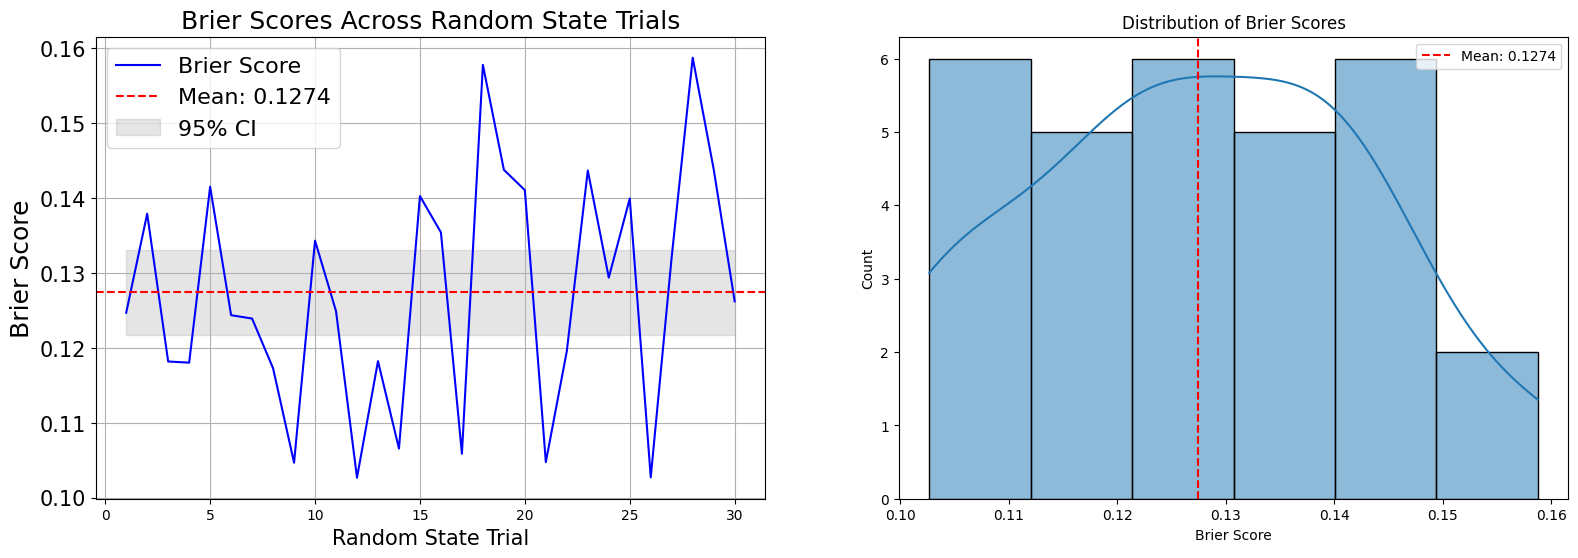

In [47]:
brier_scores(results)

Check Brier scores

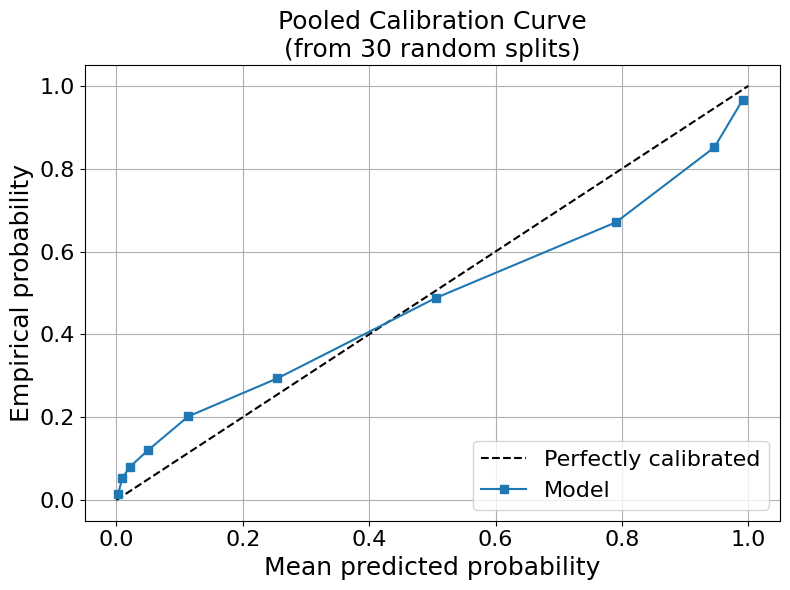

In [48]:
calibration_plot(results)